# Psychological evaluation of written chats between cyber actors
**Originally** "the main contribution is to try to identify what events can cause tension in cybercrime groups using the Conti leaks as the use case". **Changed to** "the main contribution is a methodology to analyse psychological aspects in written conversation between cyberthreat actors. A secondary contribution is a set of advises on how victims' cyber negotiators could use psychological observations in their favor." I still would like to add something on **"social engineering"**. 


## RQ: What psychological aspects can be extrapolated from digital conversations?
Examples (TODO: need a good definition):
- Emotion (anger, fear, agony, anticipation, embarrassment, anxiety, depression, trust, surprise, sadness, joy, happiness, disgust, ...)
- Behavior (aggressive, ...)
- Connection
- Hierarchy  

### What can be automated? What papers, libraries and methods exist?
- NRC Emotion Lexicon. The NRC Emotion Lexicon is a list of English words and their associations with 8 basic emotions (anger, fear, anticipation, trust, surprise, sadness, joy, and disgust) and 2 sentiments (negative and positive). [Link!](https://saifmohammad.com/WebPages/NRC-Emotion-Lexicon.htm)
- Valence Aware Dictionary and Sentiment Reasoner (VADER)
- Happy Transformer
- TODO: 
  - Text2emotion
  - FLAIR
  - NLTK
 

1. A message -> psy_analyse()
2. Event/date -> psy_analyse() context
  - https://krebsonsecurity.com/2022/03/conti-ransomware-group-diaries-part-i-evasion/
  - https://krebsonsecurity.com/2022/03/conti-ransomware-group-diaries-part-ii-the-office/
  - https://krebsonsecurity.com/2022/03/conti-ransomware-group-diaries-part-iii-weaponry/
  - https://krebsonsecurity.com/2022/03/conti-ransomware-group-diaries-part-iv-cryptocrime/


## 1. Reading the data (Conti ransomware leaked chat, translated by Northwave Security)

In [19]:
import pandas as pd

In [21]:
df_2020 = pd.read_csv('https://github.com/NorthwaveSecurity/complete_translation_leaked_chats_conti_ransomware/blob/main/jabber_chat_2020_translated.csv?raw=true',index_col=0)
df_2021 = pd.read_csv('https://github.com/NorthwaveSecurity/complete_translation_leaked_chats_conti_ransomware/blob/main/jabber_chat_2021_2022_translated.csv?raw=true',index_col=0)
df = pd.concat([df_2020,df_2021]).reset_index(drop=True)

Converting 

In [22]:
df['ts'] = pd.to_datetime(df['ts'])
df = df.set_index('ts', drop=True) 

## 2. Visualizing the data

In [23]:
grouped_msg_per_day = df.groupby(pd.Grouper(freq='D')).size()
grouped_msg_per_day.index = grouped_msg_per_day.index.to_pydatetime()

In [38]:
import datetime as dt
import matplotlib.pyplot as plt# http://matplotlib.org/gallery.html 
plt.style.use('ggplot') # https://matplotlib.org/3.1.1/gallery/style_sheets/style_sheets_reference.html
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

plt.rcParams.update({'text.color' : "grey", 'font.family' : "sans-serif", 'font.size' : "14"})

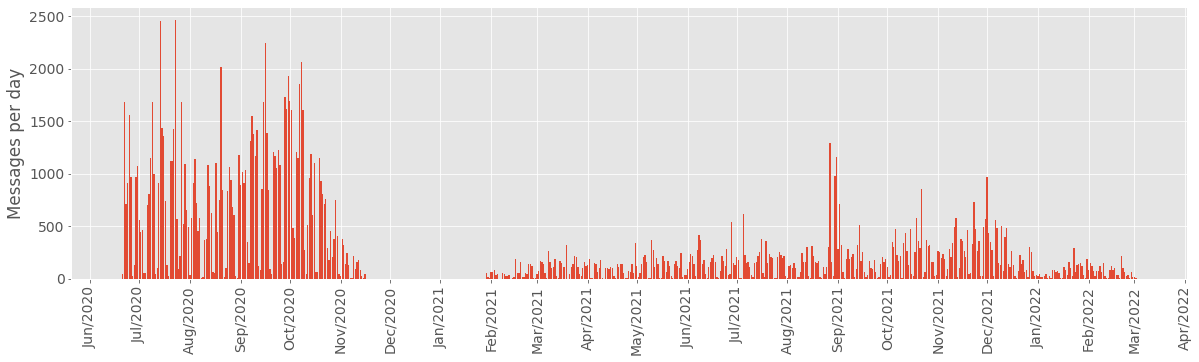

In [50]:
fig = plt.figure(figsize=(20, 5))
ax = plt.subplot2grid((1,1), (0,0))

ax.bar(grouped_msg_per_day.index, grouped_msg_per_day) #this usually is the problem with timeseries I do data.plot() DOESN'T WORK
ax.set_ylabel("Messages per day")

ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b/%Y'))
ax.tick_params(axis='x', rotation=90)

# ax.set_xlim([pd.Timestamp('2020-06-01 00:00:00'), pd.Timestamp('2022-05-01 00:00:00')])
# ax.set_ylim([0, 4000])


plt.savefig('figs/jabber_timeseries_num_messages.eps', bbox_inches='tight',format='eps', dpi=1200)#, transparent=True
plt.show()

## Annotating the graph

In [76]:
annotations = [['2021-01-26', 'Alla Witte Arrested','https://www.bleepingcomputer.com/news/security/us-charges-latvian-for-helping-develop-the-trickbot-malware/'],
               ['2022-01-14', 'Arrest 14 ReVIL actors','http://www.fsb.ru/fsb/press/message/single.htm%21id%3D10439388%40fsbMessage.html'],
               ['2022-02-24','Russia invades Ukraine'],
               ['2022-02-25','Conti admin declare support to Russia']
             ]

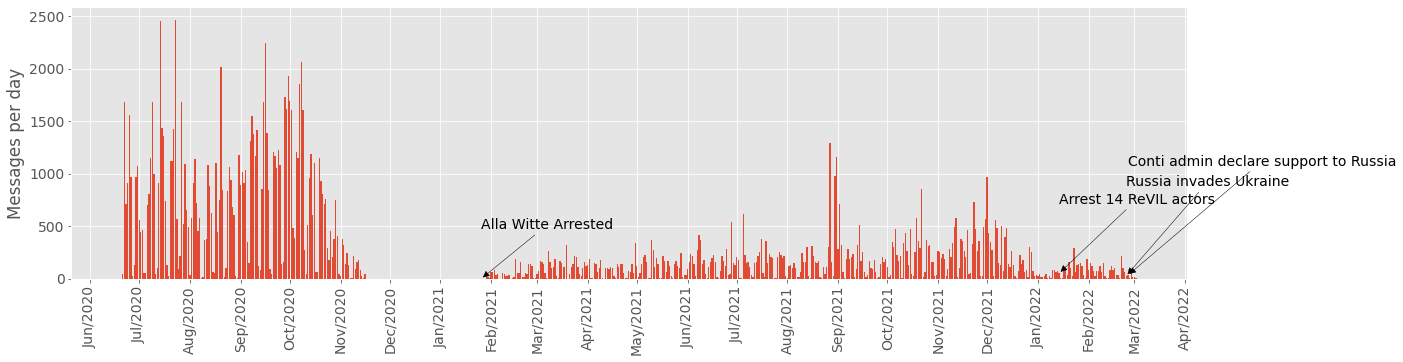

In [77]:
fig = plt.figure(figsize=(20, 5))
ax = plt.subplot2grid((1,1), (0,0))

ax.bar(grouped_msg_per_day.index, grouped_msg_per_day) #this usually is the problem with timeseries I do data.plot() DOESN'T WORK
ax.set_ylabel("Messages per day")

ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b/%Y'))
ax.tick_params(axis='x', rotation=90)

# ax.set_xlim([pd.Timestamp('2020-06-01 00:00:00'), pd.Timestamp('2022-05-01 00:00:00')])


###### Loop for Annotations
y_value=50
for annotation in annotations:
    ax.annotate(annotation[1], (pd.Timestamp(annotation[0]), grouped_msg_per_day[pd.Timestamp(annotation[0])]), 
                xytext=(0, y_value), color='black',
                textcoords='offset points', 
                arrowprops=dict(arrowstyle='-|>',color='black'))
    y_value+=20
    
# ax.set_ylim([0, 4000])

plt.savefig('figs/jabber_timeseries_num_messages_annotated.eps', bbox_inches='tight',format='eps', dpi=1200)#, transparent=True
plt.show()

## Sentiment. Pre-trained models. NRC emotion Lexicon

In [90]:
# !pip install nrclex
from nrclex import NRCLex #NRC Emotion Lexicon
 
input_text = "I am very happy"
emotion = NRCLex(input_text).affect_frequencies

print(emotion)

{'fear': 0.0, 'anger': 0.0, 'anticip': 0.0, 'trust': 0.25, 'surprise': 0.0, 'positive': 0.25, 'negative': 0.0, 'sadness': 0.0, 'disgust': 0.0, 'joy': 0.25, 'anticipation': 0.25}


## Sentiment. Pre-trained models. VADER (Valence Aware Dictionary and Sentiment Reasoner) model

In [92]:
# !pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
 
def sentiment_scores(sentence):
 
    sid_obj = SentimentIntensityAnalyzer()
    sentiment_dict = sid_obj.polarity_scores(sentence)
    
    if sentiment_dict['compound'] >= 0.05 :
        sentiment = "Positive"
    elif sentiment_dict['compound'] <= -0.05 :
        sentiment = "Negative"
    else :
        sentiment ="Neutral" 
    
    return sentiment_dict, sentiment
   
input_text = "I am very happy"
sentiment_scores(input_text)

({'neg': 0.0, 'neu': 0.429, 'pos': 0.571, 'compound': 0.6115}, 'Positive')

## Sentiment. Pre-trained models. Happy Transformer

In [96]:
# pip install happytransformer
from happytransformer import HappyTextClassification

# HappyTextClassification("BERT", "ProsusAI/finbert", num_labels=3)

happy_tc = HappyTextClassification(model_type="DISTILBERT", model_name="distilbert-base-uncased-finetuned-sst-2-english", num_labels=2)

input_text = "I am very happy"
result = happy_tc.classify_text(input_text)
print(result.label)

01/18/2023 15:20:14 - INFO - happytransformer.happy_transformer -   Using model: cpu


POSITIVE


## Sentiment. Pre-trained models. TextBlob

In [100]:
# !pip install textblob

from textblob import TextBlob

input_text = "I am very happy"
  
classifier = TextBlob(input_text)
polarity = classifier.sentiment.polarity
subjectivity = classifier.sentiment.subjectivity
    
print(polarity, subjectivity)

1.0 1.0


## Sentiment. Pre-trained models. TODO make Text2emotion to work
## Sentiment. Pre-trained models. TODO make FLAIR to work
## Sentiment. Pre-trained models. TODO make nltk to work